In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
import sys

additional_paths = ['../']

for path in additional_paths:
    if path not in sys.path:
        sys.path.append(path)

In [4]:
import os
import utils.pong
import utils.model
import utils.visualization
import utils.tensorflow

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pydot
import datetime
import random

tf.__version__

'2.0.0'

In [5]:
SEQ_LEN = 256
W, H = 40, 40

stateful_pong_generator = utils.pong.StatefulPongGenerator(W, H, SEQ_LEN, stochasticity=0.1)

def data_input():
    for (d, c), (f, g) in stateful_pong_generator:
        stateful_pong_generator.stochasticity = random.uniform(0, 1)
        yield (np.array([np.sin(d), np.cos(d)]), c), f

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), tf.float32),
).take(8000).cache().repeat().batch(bs).prefetch(tf.data.experimental.AUTOTUNE)

list(make_dataset(10).take(5))[0][0][1].shape

TensorShape([10, 256, 2])

In [6]:
model = utils.model.Model(32, W, H)
model.net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
game_init (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
project_activation (Dense)      (None, 32)           96          game_init[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 32)     3456        user_input[0][0]                 
                                                                 project_activation[0][0]     

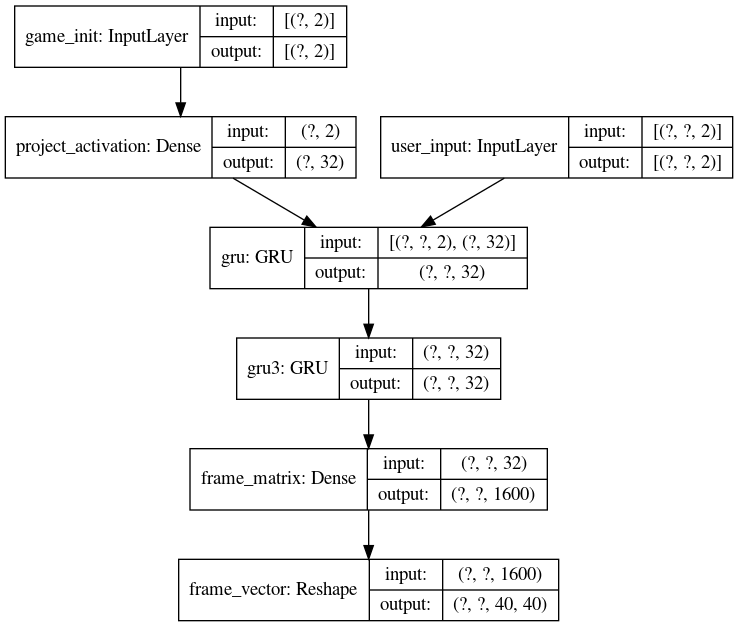

In [7]:
tf.keras.utils.plot_model(model.net, to_file='model.png', show_shapes=True, expand_nested=False)

In [8]:
checkpoint_dir = '.checkpoint/'
cp_file_name = 'cp.{epoch:0004d}-{loss:.5f}.hdf5'

!mkdir {checkpoint_dir}

mkdir: cannot create directory ‘.checkpoint/’: File exists


In [9]:
latest = tf.train.latest_checkpoint(checkpoint_dir, latest_filename=cp_file_name)
sorted_by_date = sorted([checkpoint_dir + f for f in os.listdir(checkpoint_dir)], key=os.path.getmtime)

if latest is None and len(sorted_by_date) > 0:
    latest = sorted_by_date[-1]

latest

In [10]:
if latest:
    model.net.load_weights(latest)

In [28]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir + cp_file_name,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=300,
    mode='min'
)

custom_callback = utils.tensorflow.on_batch_begin(
    lambda: utils.visualization.plot_pairwise_frames(
        sampler=lambda: list(make_dataset(1).take(1))[0],
        hypotheses=lambda x: model.net.predict(x)[0]
    )
)

In [29]:
callbacks = [
    custom_callback,
    early_stopping_callback,
    checkpoint_callback,
    model.tb_callback
]

In [48]:
input_generator = make_dataset(bs=128)

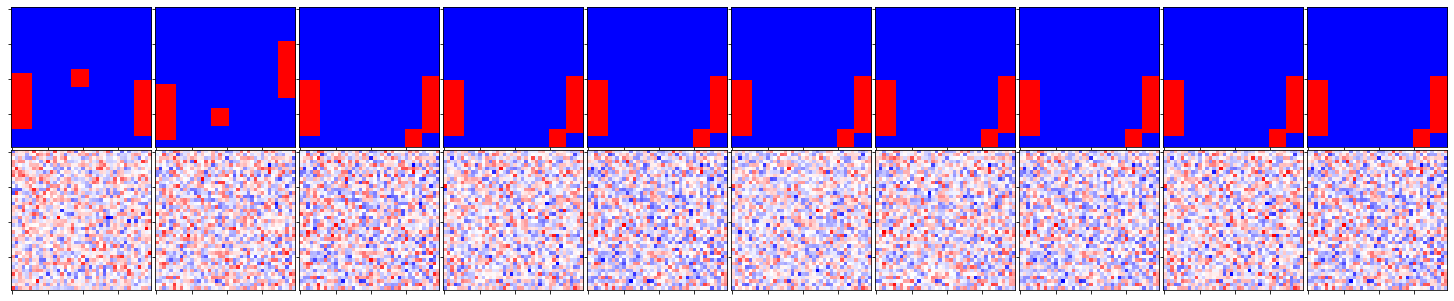

Epoch 1/2500
 11/128 [=>............................] - ETA: 1:58 - loss: 0.6376 - mse: 0.2228

In [ ]:
model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=128,
    epochs=2500,
    callbacks=callbacks
)